<a href="https://colab.research.google.com/github/kevinvbc/deeproad/blob/transportation_cost_gamma/Gorilla_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gorilla Data Engineer Assignment

In [1]:
import pandas as pd
import numpy as np
import random
from itertools import product
import timeit
import seaborn as sns


In [2]:
# get data from repo
!wget "https://raw.githubusercontent.com/kevinvbc/deeproad/master/gorilla_test_data.xlsx"
xls = pd.ExcelFile('gorilla_test_data.xlsx')
meter_list = pd.read_excel(xls, 'meter_list')
forecast_table = pd.read_excel(xls, 'forecast_table')
rate_table = pd.read_excel(xls, 'rate_table')

--2023-03-22 17:01:32--  https://raw.githubusercontent.com/kevinvbc/deeproad/master/gorilla_test_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141433 (138K) [application/octet-stream]
Saving to: ‘gorilla_test_data.xlsx.7’

gorilla_test_data.x 100%[===================>] 138.12K  --.-KB/s    in 0.02s   

2023-03-22 17:01:32 (8.15 MB/s) - ‘gorilla_test_data.xlsx.7’ saved [141433/141433]



##Exploratory Data Analysis + Preprocessing


In [3]:
# EDA
forecast_table

,meter_id,date,kwh
0,14676236,2020-06-01,22.070768
1,14676236,2020-06-02,19.170720
2,14676236,2020-06-03,23.555111
3,14676236,2020-06-04,18.220712
4,14676236,2020-06-05,14.196134
...,...,...,...
3407,88357331,2022-09-27,441.014725
3408,88357331,2022-09-28,441.512055
3409,88357331,2022-09-29,437.240657
3410,88357331,2022-09-30,517.608354


In [4]:
# aq_max_kwh column seems to have NaNs
rate_table['aq_max_kwh'].unique()
rate_table[(rate_table['aq_max_kwh'].isna())]

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
2,2020-04-01,EA1,732000,NaN,0.2875
5,2020-04-01,EA2,732000,NaN,0.1849
8,2020-04-01,EA3,732000,NaN,0.2492
11,2020-04-01,EA4,732000,NaN,0.2889
14,2020-04-01,EM1,732000,NaN,0.2734
...,...,...,...,...,...
1127,2024-10-01,WA1,732000,NaN,0.8735
1130,2024-10-01,WA2,732000,NaN,0.5638
1133,2024-10-01,WM1,732000,NaN,0.6461
1136,2024-10-01,WM2,732000,NaN,0.7534


In [5]:
# fill NaNs with very large value for aq_max_kwh 
large_value = 5000000 # place holder

# aq_max_kwh can be an integer, just like aq_min_kwh
rate_table['aq_max_kwh'] = rate_table['aq_max_kwh'].fillna(large_value)
rate_table['aq_max_kwh'] = rate_table['aq_max_kwh'].astype('int64')

rate_table


,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200,0.2652
1,2020-04-01,EA1,73200,732000,0.1980
2,2020-04-01,EA1,732000,5000000,0.2875
3,2020-04-01,EA2,0,73200,0.2970
4,2020-04-01,EA2,73200,732000,0.1524
...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000,0.4537
1136,2024-10-01,WM2,732000,5000000,0.7534
1137,2024-10-01,WM3,0,73200,0.7263
1138,2024-10-01,WM3,73200,732000,0.6109


In [6]:
# add date on which rate finishes to rate_table
rate_table['finish_date'] = rate_table.groupby(['exit_zone','aq_min_kwh'])['date'].shift(-1)
rate_table['finish_date'] = rate_table['finish_date'].fillna(rate_table['date'])
rate_table

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,finish_date
0,2020-04-01,EA1,0,73200,0.2652,2020-10-01
1,2020-04-01,EA1,73200,732000,0.1980,2020-10-01
2,2020-04-01,EA1,732000,5000000,0.2875,2020-10-01
3,2020-04-01,EA2,0,73200,0.2970,2020-10-01
4,2020-04-01,EA2,73200,732000,0.1524,2020-10-01
...,...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000,0.4537,2024-10-01
1136,2024-10-01,WM2,732000,5000000,0.7534,2024-10-01
1137,2024-10-01,WM3,0,73200,0.7263,2024-10-01
1138,2024-10-01,WM3,73200,732000,0.6109,2024-10-01


In [7]:
# join forecast and meter table to access exit_zone information
# set index and using .join() is optimal way of joining pandas dataframes
forecast_per_zone = forecast_table.set_index('meter_id').join(meter_list.set_index('meter_id'), on = "meter_id", how = "inner")
forecast_per_zone = forecast_per_zone.sort_values(['date', 'exit_zone'])
forecast_per_zone

,date,kwh,aq_kwh,exit_zone
meter_id,,,,
14676236,2020-06-01,22.070768,28978,EA1
50264822,2020-06-01,278.759084,265667,NT1
88357331,2020-06-01,343.883152,484399,SE2
34509937,2020-06-01,78.611504,78324,SO1
14676236,2020-06-02,19.170720,28978,EA1
...,...,...,...,...
34509937,2022-09-30,81.478131,78324,SO1
14676236,2022-10-01,37.122479,28978,EA1
50264822,2022-10-01,328.192979,265667,NT1


In [8]:
def compare_annual_quantity(row):

    ''' This function retrieves the applicable rate from the rate_table and returns it '''

    # Make a Boolean mask that adheres to the conditions of the correct rate
    mask =   (rate_table['date'] <= row['date']) & (rate_table['finish_date'] > row['date'])  & (rate_table['exit_zone'] == row['exit_zone']) & (rate_table['aq_min_kwh'] <= row['aq_kwh']) & (rate_table['aq_max_kwh'] > row['aq_kwh'])
    relevant_rows = rate_table.loc[mask]

    # Return the relevant rates
    if len(relevant_rows) == 0:
        return None
    else:
        
        return relevant_rows['rate_p_per_kwh'].squeeze()




In [9]:
#Add the relevant rates to the forecast table for each day and for each meter

forecast_per_zone['relevant_rate_p_per_kwh'] = forecast_per_zone.apply(compare_annual_quantity, axis=1).astype('float')
forecast_per_zone

,date,kwh,aq_kwh,exit_zone,relevant_rate_p_per_kwh
meter_id,,,,,
14676236,2020-06-01,22.070768,28978,EA1,0.2652
50264822,2020-06-01,278.759084,265667,NT1,0.2181
88357331,2020-06-01,343.883152,484399,SE2,0.2318
34509937,2020-06-01,78.611504,78324,SO1,0.2743
14676236,2020-06-02,19.170720,28978,EA1,0.2652
...,...,...,...,...,...
34509937,2022-09-30,81.478131,78324,SO1,0.4316
14676236,2022-10-01,37.122479,28978,EA1,0.4674
50264822,2022-10-01,328.192979,265667,NT1,0.3844


In [10]:
# Compute daily charge
forecast_per_zone['daily_charge'] = forecast_per_zone['relevant_rate_p_per_kwh']*forecast_per_zone['kwh']
forecast_per_zone

,date,kwh,aq_kwh,exit_zone,relevant_rate_p_per_kwh,daily_charge
meter_id,,,,,,
14676236,2020-06-01,22.070768,28978,EA1,0.2652,5.853168
50264822,2020-06-01,278.759084,265667,NT1,0.2181,60.797356
88357331,2020-06-01,343.883152,484399,SE2,0.2318,79.712115
34509937,2020-06-01,78.611504,78324,SO1,0.2743,21.563136
14676236,2020-06-02,19.170720,28978,EA1,0.2652,5.084075
...,...,...,...,...,...,...
34509937,2022-09-30,81.478131,78324,SO1,0.4316,35.165961
14676236,2022-10-01,37.122479,28978,EA1,0.4674,17.351047
50264822,2022-10-01,328.192979,265667,NT1,0.3844,126.157381


In [11]:
# Total cost and consumption per meter in pounds
total_cost_per_meter =  pd.DataFrame((forecast_per_zone['daily_charge'].groupby('meter_id').sum()*0.01).round(2))
total_cost_per_meter.rename(columns={"daily_charge": "Total_cost(pounds)"},inplace=True)
total_cost_per_meter['Total Estimated Consumption(kWh)'] = (forecast_per_zone['kwh'].groupby('meter_id').sum().round(2))
total_cost_per_meter

,Total_cost(pounds),Total Estimated Consumption(kWh)
meter_id,,
14676236,100.15,28978.0
34509937,275.49,78324.0
50264822,731.24,265667.0
88357331,1433.16,484399.0


##Random Meter Generator

In [12]:
def meter_generator(size):
  """This function takes in an amount of meters it needs to randomly generate and outputs a list of meters with annual quantities and exit_zones"""
  
  valid_exit_zones = rate_table['exit_zone'].unique().tolist()
  meter_ids = random.sample(range(10000000, 99999999), size)
  annual_quantities = random.sample(range(10000, 100000), size)
  exit_zones = random.choices(valid_exit_zones, k= size) #sample from list of valid exit zones with replacement

  meter_list = [list(x) for x in zip(meter_ids, annual_quantities, exit_zones)]

  return meter_list
  


In [13]:
meters = meter_generator(10)
meters

[[99037502, 64058, 'EA2'],
 [29152713, 17569, 'NO2'],
 [62909591, 50843, 'LW'],
 [97602704, 55976, 'WM2'],
 [74775414, 40978, 'SO1'],
 [89212401, 96017, 'LO'],
 [14258791, 84427, 'EA4'],
 [12480177, 57882, 'EM4'],
 [76521492, 11211, 'NO2'],
 [44551644, 79114, 'WA2']]

## Mock Consumption Data Generator

In [14]:
# define start date for this dataset
forecast_start_date = forecast_table['date'].min()

def mock_consumption_generator(meter_list, start_date = forecast_start_date, duration = 852):

  """ This function takes in a list of meters , a start date and a duration in number of days and outputs mock consumption data"""

  #initialize dataframe as combination of meter_ids and dates
  datelist = pd.date_range(forecast_start_date, periods=duration).tolist()
  meter_id_list = list(list(zip(*meter_list))[0])
  df = pd.DataFrame(list(product(meter_id_list, datelist)), columns=['meter_id', 'date'])
  # create random floats for forecast per day
  size = len(meter_list)*duration
  integer_list = random.sample(range(100000, 10000000), size)
  df['kWh'] = [round(x/100000,5) for x in integer_list]


  return df


In [15]:
mock_data = mock_consumption_generator(meters)
mock_data

,meter_id,date,kWh
0,99037502,2020-06-01,93.09136
1,99037502,2020-06-02,75.90631
2,99037502,2020-06-03,65.80168
3,99037502,2020-06-04,36.38759
4,99037502,2020-06-05,11.11739
...,...,...,...
8515,44551644,2022-09-26,38.68504
8516,44551644,2022-09-27,13.20786
8517,44551644,2022-09-28,45.41333
8518,44551644,2022-09-29,82.13105


## Benchmarking transportation cost table function

In [16]:
def transportation_cost(meter_list: list, consumption_forecast) :
  
  """ This function takes a meter list and consumption forecast table in the form of a pandas dataframe and returns the consumption forecast table in a pandas dataframe """

  meter_list = pd.DataFrame(meter_list, columns = ['meter_id', 'aq_kwh','exit_zone'])
  forecast_per_zone_df = consumption_forecast.set_index('meter_id').join(meter_list.set_index('meter_id'), on = "meter_id", how = "left").reset_index()
  print('Number of days before join: ', forecast_per_zone_df.shape )
  merge_df = rate_table.merge(forecast_per_zone_df, how="cross")
  print('Number of days after join: ', merge_df.shape )


  # filter relevant rows for correct rate (date_x is start date for rate determination, date_y is consumption date)
  relevant_rate_df = merge_df[(merge_df.date_x <= merge_df.date_y) & (merge_df.finish_date > merge_df.date_y) & (merge_df.exit_zone_x == merge_df.exit_zone_y) & (merge_df.aq_min_kwh <= merge_df.aq_kwh) & (merge_df.aq_max_kwh > merge_df.aq_kwh)]
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
  relevant_rate_df= relevant_rate_df.set_index('meter_id')
  
  # Total cost in pounds and consumption per meter 
  total_cost_and_consumption = pd.DataFrame((relevant_rate_df['transportation_cost'].groupby('meter_id').sum()*0.01).round(2))
  total_cost_and_consumption.rename(columns={"transportation_cost": "Total_cost(pounds)"},inplace=True)
  total_cost_and_consumption['Total Estimated Consumption(kWh)'] = (relevant_rate_df['kWh'].groupby('meter_id').sum().round(2))


  return total_cost_and_consumption



In [17]:
total_cost_and_consumption = transportation_cost(meters,mock_data)
total_cost_and_consumption

Number of days before join:  (8520, 5)
Number of days after join:  (9712800, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


,Total_cost(pounds),Total Estimated Consumption(kWh)
meter_id,,
12480177,125.69,45055.86
14258791,163.40,42858.55
29152713,151.69,41720.26
44551644,160.53,43425.40
62909591,132.91,42168.93
74775414,107.32,43830.96
76521492,158.10,43587.56
89212401,156.93,44757.69
97602704,166.89,44035.31


In [18]:
# Better version of transportation_cost() using an inner join before filter instead of a cross join
def transportation_cost_beta(meter_list: list, consumption_forecast) :
  
  """ This function takes a meter list and consumption forecast table in the form of a pandas dataframe and returns the consumption forecast table in a pandas dataframe """

  meter_list = pd.DataFrame(meter_list, columns = ['meter_id', 'aq_kwh','exit_zone'])
  forecast_per_zone_df = consumption_forecast.set_index('meter_id').join(meter_list.set_index('meter_id'), on = "meter_id", how = "inner").reset_index()
  print('Number of rows forecast_per_zone before join: ', forecast_per_zone_df.shape[0] )
  print('Number of rows rate_table before join: ', rate_table.shape[0] )

  
  rates_per_day = rate_table.merge(forecast_per_zone_df, on = "exit_zone", how = "inner")
  print('Number of rows after join: ', rates_per_day.shape[0] )


  # filter relevant rows for correct rate (date_x is start date for rate determination, date_y is consumption date)
  relevant_rate_df = rates_per_day.where((rates_per_day.date_x <= rates_per_day.date_y) & (rates_per_day.finish_date > rates_per_day.date_y) & (rates_per_day.aq_min_kwh <= rates_per_day.aq_kwh) & (rates_per_day.aq_max_kwh > rates_per_day.aq_kwh)).dropna()
  print('Number of rows after filter: ', relevant_rate_df.shape[0] )
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
  relevant_rate_df= relevant_rate_df.set_index('meter_id')
  
  # Total cost in pounds and consumption per meter 
  total_cost_and_consumption = pd.DataFrame((relevant_rate_df['transportation_cost'].groupby('meter_id').sum()*0.01).round(2))
  total_cost_and_consumption.rename(columns={"transportation_cost": "Total_cost(pounds)"},inplace=True)
  total_cost_and_consumption['Total Estimated Consumption(kWh)'] = (relevant_rate_df['kWh'].groupby('meter_id').sum().round(2))


  return total_cost_and_consumption

In [19]:
# Gamma version 
def add_kWh_range_index(rate_table, forecast_per_zone):

  """This function creates a range index for both a rate table and a forecast_per_zone table """
  forecast_per_zone = forecast_per_zone.reset_index()

  # make a dictionary that maps each unique range to an integer
  unique_ranges = rate_table[['aq_min_kwh','aq_max_kwh']].drop_duplicates().reset_index()

  # STILL TO DO : replace max value with infinity before creating bins AND replace hard-coded bins by read-in from dictionary

  #unique_ranges['aq_max_kwh'].replace(unique_ranges['aq_max_kwh'].max(), np.inf, inplace=True)
  unique_ranges['range_tuple'] = list(zip(unique_ranges.aq_min_kwh, unique_ranges.aq_max_kwh))
  unique_range_dict = dict(zip(unique_ranges.range_tuple, unique_ranges.index))

  # make range_tuple for rate_table
  rate_table['range_tuple'] = list(zip(rate_table.aq_min_kwh, rate_table.aq_max_kwh))


  # map range_tuple on range_idx
  rate_table['range_idx']= rate_table['range_tuple'].map(unique_range_dict)


  # Map annual kWh to range it belongs (integer index)

  #bins = pd.IntervalIndex.from_tuples([bin for bin in unique_range_dict.keys()], closed='left')
  #bins_dict = dict(zip(bins,))
  #bins = [bin for bin in unique_range_dict.keys()]

  forecast_per_zone['range_idx'] = pd.cut(forecast_per_zone['aq_kwh'] , bins=[0,73200,732000,5000000], labels = False)
  return  rate_table, forecast_per_zone


  

def transportation_cost_gamma(meter_list: list, consumption_forecast) :
  
  """ This function takes a meter list and consumption forecast table in the form of a pandas dataframe and returns the consumption forecast table in a pandas dataframe """

  meter_list = pd.DataFrame(meter_list, columns = ['meter_id', 'aq_kwh','exit_zone'])
  forecast_per_zone_df = consumption_forecast.set_index('meter_id').join(meter_list.set_index('meter_id'), on = "meter_id", how = "inner").reset_index()
  
  # Add extra range_idx key before merging
  rates, forecast_per_zone = add_kWh_range_index(rate_table, forecast_per_zone_df)
  rates_per_day = rates.merge(forecast_per_zone, on = ["exit_zone", "range_idx"], how = "inner")
  print('Number of rows after join: ', rates_per_day.shape[0] )


  # filter relevant rows for correct rate (date_x is start date for rate determination, date_y is consumption date)
  relevant_rate_df = rates_per_day.where((rates_per_day.date_x <= rates_per_day.date_y) & (rates_per_day.finish_date > rates_per_day.date_y) & (rates_per_day.aq_min_kwh <= rates_per_day.aq_kwh) & (rates_per_day.aq_max_kwh > rates_per_day.aq_kwh)).dropna()
  print('Number of rows after filter: ', relevant_rate_df.shape[0] )
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
  relevant_rate_df= relevant_rate_df.set_index('meter_id')
  
  # Total cost in pounds and consumption per meter 
  total_cost_and_consumption = pd.DataFrame((relevant_rate_df['transportation_cost'].groupby('meter_id').sum()*0.01).round(2))
  total_cost_and_consumption.rename(columns={"transportation_cost": "Total_cost(pounds)"},inplace=True)
  total_cost_and_consumption['Total Estimated Consumption(kWh)'] = (relevant_rate_df['kWh'].groupby('meter_id').sum().round(2))


  return total_cost_and_consumption

In [20]:
# Settings for benchmarking
def run_benchmark(meters, mock_data):
    setup_code = """from __main__ import transportation_cost
    """
    statement = f"transportation_cost_test()"
    execution_time = timeit.timeit(stmt=statement, setup="from __main__ import transportation_cost_test", number=5)
    return execution_time

meter_list_sizes = [10,20,50]
durations = [10,100, 1000]

meter_list_sizes_beta = [10,20,50,100]
durations_beta = [10,100, 1000, 5000,10000]

meter_list_sizes_gamma = [10,20,50,100]
durations_gamma = [10,100, 1000, 5000,10000]

results = []
results_beta = []
results_gamma = []



In [21]:
# Benchmarking transportation_cost()
for d in durations:
  for m in meter_list_sizes:
    meters = meter_generator(m)
    
    mock_data = mock_consumption_generator(meters, duration=d)

    def transportation_cost_test():
      transportation_cost(meters,mock_data)

    execution_time = run_benchmark(meters, mock_data)
    print("Execution time for meter size of ", m, "and duration of ", d, " was ", execution_time)
    results.append({'meter_list_size': m, 'duration': d, 'execution_time': execution_time})

execution_times_df = pd.DataFrame(results)

Number of days before join:  (100, 5)
Number of days after join:  (114000, 11)
Number of days before join:  (100, 5)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days after join:  (114000, 11)
Number of days before join:  (100, 5)
Number of days after join:  (114000, 11)
Number of days before join:  (100, 5)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days after join:  (114000, 11)
Number of days before join:  (100, 5)
Number of days after join:  (114000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  10 and duration of  10  was  0.6918764549991465
Number of days before join:  (200, 5)
Number of days after join:  (228000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']
<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (200, 5)
Number of days after join:  (228000, 11)
Number of days before join:  (200, 5)
Number of days after join:  (228000, 11)
Number of days before join:  (200, 5)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days after join:  (228000, 11)
Number of days before join:  (200, 5)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days after join:  (228000, 11)
Execution time for meter size of  20 and duration of  10  was  1.0957837470014056
Number of days before join:  (500, 5)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days after join:  (570000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (500, 5)
Number of days after join:  (570000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (500, 5)
Number of days after join:  (570000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (500, 5)
Number of days after join:  (570000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (500, 5)
Number of days after join:  (570000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  50 and duration of  10  was  3.8170055560003675
Number of days before join:  (1000, 5)
Number of days after join:  (1140000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (1000, 5)
Number of days after join:  (1140000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (1000, 5)
Number of days after join:  (1140000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (1000, 5)
Number of days after join:  (1140000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (1000, 5)
Number of days after join:  (1140000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  10 and duration of  100  was  1.9587423670018325
Number of days before join:  (2000, 5)
Number of days after join:  (2280000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (2000, 5)
Number of days after join:  (2280000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (2000, 5)
Number of days after join:  (2280000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (2000, 5)
Number of days after join:  (2280000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (2000, 5)
Number of days after join:  (2280000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  20 and duration of  100  was  3.902856348999194
Number of days before join:  (5000, 5)
Number of days after join:  (5700000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (5000, 5)
Number of days after join:  (5700000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (5000, 5)
Number of days after join:  (5700000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (5000, 5)
Number of days after join:  (5700000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (5000, 5)
Number of days after join:  (5700000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  50 and duration of  100  was  11.032975106001686
Number of days before join:  (10000, 5)
Number of days after join:  (11400000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (10000, 5)
Number of days after join:  (11400000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (10000, 5)
Number of days after join:  (11400000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (10000, 5)
Number of days after join:  (11400000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (10000, 5)
Number of days after join:  (11400000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  10 and duration of  1000  was  22.63082860600116
Number of days before join:  (20000, 5)
Number of days after join:  (22800000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (20000, 5)
Number of days after join:  (22800000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (20000, 5)
Number of days after join:  (22800000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (20000, 5)
Number of days after join:  (22800000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (20000, 5)
Number of days after join:  (22800000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  20 and duration of  1000  was  55.2277894200015
Number of days before join:  (50000, 5)
Number of days after join:  (57000000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (50000, 5)
Number of days after join:  (57000000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (50000, 5)
Number of days after join:  (57000000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (50000, 5)
Number of days after join:  (57000000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of days before join:  (50000, 5)
Number of days after join:  (57000000, 11)


<ipython-input-16-3aaf95b62e94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Execution time for meter size of  50 and duration of  1000  was  117.57182165400081


In [22]:
# Benchmarking transportation_cost_beta()
for d in durations_beta:
  for m in meter_list_sizes_beta:
    meters = meter_generator(m)
    
    mock_data = mock_consumption_generator(meters, duration=d)

    def transportation_cost_test():
      transportation_cost_beta(meters,mock_data)

    execution_time = run_benchmark(meters, mock_data)
    print("Beta execution time for meter size of ", m, "and duration of ", d, " was ", execution_time)
    results_beta.append({'meter_list_size': m, 'duration': d, 'execution_time': execution_time})

execution_times_df_beta = pd.DataFrame(results_beta)

Number of rows forecast_per_zone before join:  100
Number of rows rate_table before join:  1140
Number of rows after join:  3000
Number of rows after filter:  100
Number of rows forecast_per_zone before join:  100
Number of rows rate_table before join:  1140
Number of rows after join:  3000
Number of rows after filter:  100
Number of rows forecast_per_zone before join:  100
Number of rows rate_table before join:  1140
Number of rows after join:  3000
Number of rows after filter:  100
Number of rows forecast_per_zone before join:  100
Number of rows rate_table before join:  1140
Number of rows after join:  3000
Number of rows after filter:  100
Number of rows forecast_per_zone before join:  100
Number of rows rate_table before join:  1140
Number of rows after join:  3000
Number of rows after filter:  100
Beta execution time for meter size of  10 and duration of  10  was  0.13738096399902133
Number of rows forecast_per_zone before join:  200
Number of rows rate_table before join:  1140
N

In [23]:
# Benchmarking transportation_cost_gamma()
for d in durations_gamma:
  for m in meter_list_sizes_gamma:
    meters = meter_generator(m)
    
    mock_data = mock_consumption_generator(meters, duration=d)

    def transportation_cost_test():
      transportation_cost_gamma(meters,mock_data)

    execution_time = run_benchmark(meters, mock_data)
    print("Beta execution time for meter size of ", m, "and duration of ", d, " was ", execution_time)
    results_gamma.append({'meter_list_size': m, 'duration': d, 'execution_time': execution_time})

execution_times_df_gamma = pd.DataFrame(results_gamma)

Number of rows after join:  1000
Number of rows after filter:  100
Number of rows after join:  1000
Number of rows after filter:  100
Number of rows after join:  1000
Number of rows after filter:  100
Number of rows after join:  1000
Number of rows after filter:  100
Number of rows after join:  1000
Number of rows after filter:  100
Beta execution time for meter size of  10 and duration of  10  was  0.15908171800037962
Number of rows after join:  2000
Number of rows after filter:  200
Number of rows after join:  2000
Number of rows after filter:  200
Number of rows after join:  2000
Number of rows after filter:  200
Number of rows after join:  2000
Number of rows after filter:  200
Number of rows after join:  2000
Number of rows after filter:  200
Beta execution time for meter size of  20 and duration of  10  was  0.15822508099881816
Number of rows after join:  5000
Number of rows after filter:  500
Number of rows after join:  5000
Number of rows after filter:  500
Number of rows after

<ipython-input-19-476bbbce24dc>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_rate_df['transportation_cost'] = relevant_rate_df['rate_p_per_kwh'] * relevant_rate_df['kWh']


Number of rows after join:  10000000
Number of rows after filter:  158300
Beta execution time for meter size of  100 and duration of  10000  was  55.4312688789978


In [24]:
execution_times_df = pd.pivot(execution_times_df, index='meter_list_size', columns='duration', values='execution_time')
execution_times_df_beta = pd.pivot(execution_times_df_beta, index='meter_list_size', columns='duration', values='execution_time')
execution_times_df_gamma = pd.pivot(execution_times_df_gamma, index='meter_list_size', columns='duration', values='execution_time')


<Axes: xlabel='duration', ylabel='meter_list_size'>

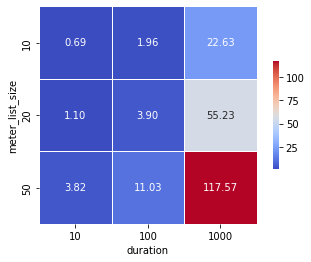

In [25]:
# execution times transportation_cost()
sns.heatmap(execution_times_df, cmap='coolwarm', annot=True, linewidths=.5, fmt=".2f", square=True, cbar_kws={"shrink": .5})

<Axes: xlabel='duration', ylabel='meter_list_size'>

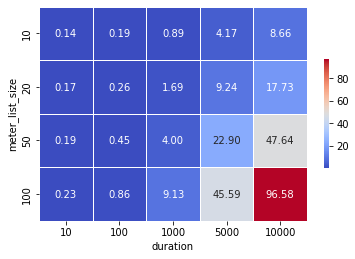

In [26]:
# execution times transportation_cost_beta()
sns.heatmap(execution_times_df_beta, cmap='coolwarm', annot=True, linewidths=.5, fmt=".2f", square=True, cbar_kws={"shrink": .5})

<Axes: xlabel='duration', ylabel='meter_list_size'>

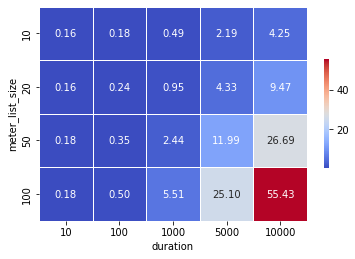

In [27]:
# execution times transportation_cost_gamma()
sns.heatmap(execution_times_df_gamma, cmap='coolwarm', annot=True, linewidths=.5, fmt=".2f", square=True, cbar_kws={"shrink": .5})